In [1]:
import torch.nn.functional as Fun
import torch
from torch import nn
import torchvision.transforms as transforms
import numpy as np
import random
random_seed = 0  
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(random_seed)
random.seed(random_seed)
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from PIL import Image
from torch.utils.data import (
    Dataset,
    DataLoader,
)

In [2]:
class PizzaDataset(Dataset):
    def __init__(self, csv_file="train.csv", root="train_196", transform=None, target_transform=None):
        self.labels = pd.read_csv(csv_file)
        self.root = root
        self.transform = transform
        self.target_transform = target_transform
    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        #print(self.root, self.labels.iloc[index, 1])
        img_path = os.path.join(self.root, self.labels.iloc[index, 1])
        img_path = os.path.join(self.root, img_path)
        image = Image.open(img_path)
        label = torch.tensor(int(self.labels.iloc[index, 2]))

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [3]:
training_data = PizzaDataset(
    csv_file="train1.csv",
    root="train_196",
    transform=transforms.Compose([transforms.RandomChoice([transforms.RandomVerticalFlip(), 
                                                           transforms.RandomHorizontalFlip(), 
                                                           transforms.RandomRotation(45)]), 
                                  transforms.ToTensor()]),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

test_data = PizzaDataset(
    csv_file="labels.csv",
    root="test_196",
    transform=transforms.ToTensor(),
    target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)

In [4]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False)

C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_33

Original Images


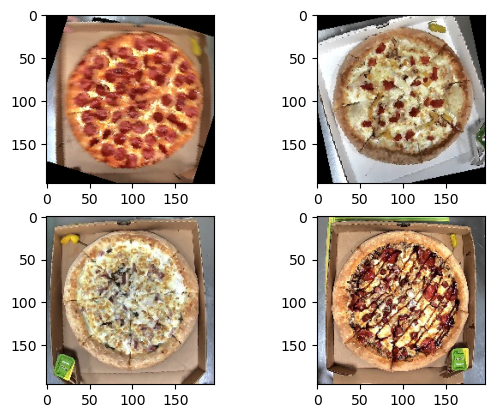

CutMix Images


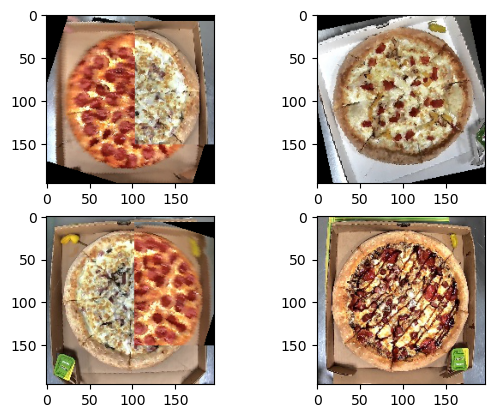

Original labels:
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])
Updated labels
tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [5]:
def rand_bbox(size, lamb):
    """ Generate random bounding box 
    Args:
        - size: [width, breadth] of the bounding box
        - lamb: (lambda) cut ratio parameter, sampled from Beta distribution
    Returns:
        - Bounding box
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lamb)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def generate_cutmix_image(image_batch, image_batch_labels, beta):
    """ Generate a CutMix augmented image from a batch 
    Args:
        - image_batch: a batch of input images
        - image_batch_labels: labels corresponding to the image batch
        - beta: a parameter of Beta distribution.
    Returns:
        - CutMix image batch, updated labels
    """
    # generate mixed sample
    lam = np.random.beta(beta, beta)
    #print(lam)
    rand_index = np.random.permutation(len(image_batch))
    target_a = image_batch_labels
    target_b = image_batch_labels[rand_index]
    bbx1, bby1, bbx2, bby2 = rand_bbox(image_batch[0][0].shape, lam)
    image_batch_updated = image_batch.numpy().copy()
    image_batch_updated[:, :, bbx1:bbx2, bby1:bby2] = image_batch[rand_index, :, bbx1:bbx2, bby1:bby2]
    
    # adjust lambda to exactly match pixel ratio
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (image_batch.shape[3] * image_batch.shape[2]))
    label = target_a * lam + target_b * (1. - lam)
    
    return torch.Tensor(image_batch_updated),label


# Generate CutMix image
# Let's use the first image of the batch as the input image to be augmented
for x, y in train_dataloader:
    image_batch = x
    image_batch_labels = y
    break
input_image = image_batch[0]
image_batch_updated, image_batch_labels_updated = generate_cutmix_image(image_batch[:4], image_batch_labels[:4], 1.0)

# Show original images
print("Original Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch[2*i+j].numpy())
        plt.imshow(np.moveaxis(image_batch[2*i+j].numpy(),0,-1))
plt.show()


# Show CutMix images
print("CutMix Images")
for i in range(2):
    for j in range(2):
        plt.subplot(2,2,2*i+j+1)
        #plt.imshow(image_batch_updated[2*i+j])
        plt.imshow(np.moveaxis(image_batch_updated[2*i+j].numpy(),0,-1))
plt.show()

# Print labels
print('Original labels:')
print(image_batch_labels)
print('Updated labels')
print(image_batch_labels_updated)

['альфредо', 'баварская', 'вегетарианская', 'ветчинаибекон', 'ветчинаигрибы', 'гавайская', 'грушаbbq', 'капричиоза', 'клубникаизефир', 'крем-чизсгрибами', 'любимаядедамороза', 'любимаякарбонара', 'любимаяпапинапицца', 'маленькаяиталия', 'маргарита', 'мексиканская', 'миксгрин', 'мясная', 'мясноебарбекю', 'новогодняя', 'палочки', 'папамикс', 'пепперони', 'пепперонигрин', 'пицца8сыровnew', 'постная', 'рождественская', 'сананасомибеконом', 'сгрушейибеконом', 'сгрушейиголубымсыром', 'сердцепепперони-4сыра', 'сердцецыпленокбарбекю-пепперони', 'сливочнаяскреветками', 'суперпапа', 'сырная', 'томатнаяскреветками', 'улыбка', 'цыпленокбарбекю', 'цыпленокгрин', 'цыпленоккордонблю', 'цыпленокрэнч', 'цыпленокфлорентина', 'чеддермексикан', 'чеддерчизбургер', 'четыресыра', 'чизбургер']


C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


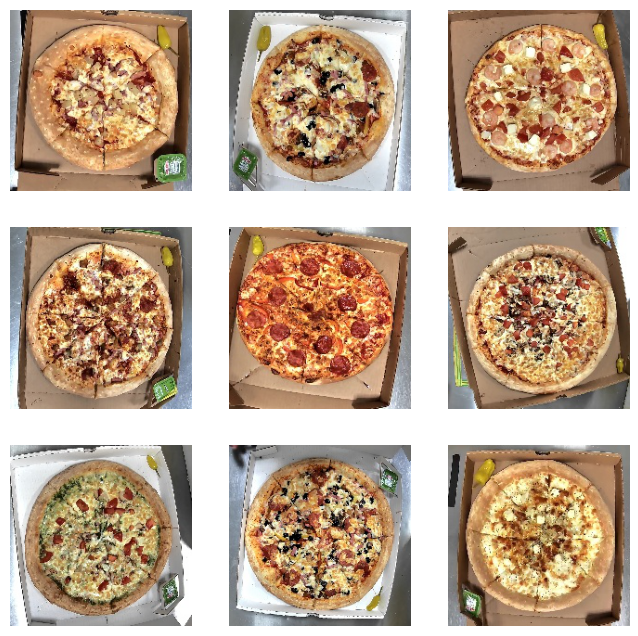

In [6]:
classes = """0: альфредо
1: баварская
2: вегетарианская
3: ветчинаибекон
4: ветчинаигрибы
5: гавайская
6: грушаbbq
7: капричиоза
8: клубникаизефир
9: крем-чизсгрибами
10: любимаядедамороза
11: любимаякарбонара
12: любимаяпапинапицца
13: маленькаяиталия
14: маргарита
15: мексиканская
16: миксгрин
17: мясная
18: мясноебарбекю
19: новогодняя
20: палочки
21: папамикс
22: пепперони
23: пепперонигрин
24: пицца8сыровnew
25: постная
26: рождественская
27: сананасомибеконом
28: сгрушейибеконом
29: сгрушейиголубымсыром
30: сердцепепперони-4сыра
31: сердцецыпленокбарбекю-пепперони
32: сливочнаяскреветками
33: суперпапа
34: сырная
35: томатнаяскреветками
36: улыбка
37: цыпленокбарбекю
38: цыпленокгрин
39: цыпленоккордонблю
40: цыпленокрэнч
41: цыпленокфлорентина
42: чеддермексикан
43: чеддерчизбургер
43: четыресыра
45: чизбургер"""

labels = classes.split()[1::2]
print(labels)
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item() # Случайный индекс из датасета
    img, label = training_data[sample_idx] # Обращение по такому индексу возвращает изображение и метку элемента датасета
    figure.add_subplot(rows, cols, i)
    #plt.title(labels[label])
    plt.axis("off")
    plt.imshow(np.moveaxis(img.numpy(),0,-1))
plt.show()

In [7]:
img.numpy().shape

(3, 196, 196)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
torch.cuda.empty_cache()

Using cuda device


In [9]:
from torchvision.models import resnext50_32x4d, ResNeXt50_32X4D_Weights

weights = ResNeXt50_32X4D_Weights.DEFAULT
model = resnext50_32x4d(weights=weights)#preprocess is also here
model.to(device)
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1

In [10]:
loss_fn = nn.CrossEntropyLoss()

In [11]:
learning_rate = 1e-3
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))

In [12]:
from tqdm import tqdm
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Получаем предсказания модели для данного батча
        X, y = generate_cutmix_image(X, y, 1.0)
        X,y = X.to(device),y.to(device)
        pred = model(X)
        # Вычисляем лосс
        loss = loss_fn(pred, y)

        # Backpropagation
        # Обнуляем градиенты
        optimizer.zero_grad()
        # Вычисляем градиент лосса по параметрам модели
        loss.backward()
        # Производим шаг алгоритма оптимизации
        optimizer.step()

        if batch % 20 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [13]:
def test_loop(dataloader, model, loss_fn, loss_list, acc_list):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    loss_list.append(test_loss)
    acc_list.append(correct)
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [14]:
def sent_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    preds = []
    with torch.no_grad():
        for X, y in dataloader:
            X,y = X.to(device),y.to(device)
            pred = model(X)
            preds.append(pred.cpu().numpy().argmax(1)[0])
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return preds

In [15]:
loss_list = []
acc_list = []

In [16]:
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devd

Epoch 1
-------------------------------
loss: 7.255397  [    0/ 6379]
loss: 2.273530  [ 1280/ 6379]
loss: 2.332189  [ 2560/ 6379]
loss: 2.115422  [ 3840/ 6379]
loss: 2.914628  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:25<08:11, 25.84s/it]

Test Error: 
 Accuracy: 82.8%, Avg loss: 0.729470 

Epoch 2
-------------------------------
loss: 1.557434  [    0/ 6379]
loss: 1.481030  [ 1280/ 6379]
loss: 1.183816  [ 2560/ 6379]
loss: 1.399093  [ 3840/ 6379]
loss: 1.213880  [ 5120/ 6379]


 10%|████████▎                                                                          | 2/20 [00:48<07:13, 24.08s/it]

Test Error: 
 Accuracy: 92.3%, Avg loss: 0.535900 

Epoch 3
-------------------------------
loss: 1.127649  [    0/ 6379]
loss: 0.625267  [ 1280/ 6379]
loss: 1.714404  [ 2560/ 6379]
loss: 1.098306  [ 3840/ 6379]
loss: 1.207657  [ 5120/ 6379]


 15%|████████████▍                                                                      | 3/20 [01:11<06:40, 23.55s/it]

Test Error: 
 Accuracy: 91.9%, Avg loss: 0.413556 

Epoch 4
-------------------------------
loss: 1.096862  [    0/ 6379]
loss: 1.292310  [ 1280/ 6379]
loss: 1.309625  [ 2560/ 6379]
loss: 1.750391  [ 3840/ 6379]
loss: 0.913470  [ 5120/ 6379]


 20%|████████████████▌                                                                  | 4/20 [01:34<06:12, 23.30s/it]

Test Error: 
 Accuracy: 93.0%, Avg loss: 0.359918 

Epoch 5
-------------------------------
loss: 0.958234  [    0/ 6379]
loss: 1.122780  [ 1280/ 6379]
loss: 0.734849  [ 2560/ 6379]
loss: 1.840271  [ 3840/ 6379]
loss: 0.605511  [ 5120/ 6379]


 25%|████████████████████▊                                                              | 5/20 [01:57<05:47, 23.17s/it]

Test Error: 
 Accuracy: 95.0%, Avg loss: 0.272547 

Epoch 6
-------------------------------
loss: 0.856718  [    0/ 6379]
loss: 1.395161  [ 1280/ 6379]
loss: 1.013292  [ 2560/ 6379]
loss: 1.019010  [ 3840/ 6379]
loss: 0.789304  [ 5120/ 6379]


 30%|████████████████████████▉                                                          | 6/20 [02:20<05:23, 23.07s/it]

Test Error: 
 Accuracy: 92.6%, Avg loss: 0.363825 

Epoch 7
-------------------------------
loss: 1.209542  [    0/ 6379]
loss: 0.643512  [ 1280/ 6379]
loss: 0.949365  [ 2560/ 6379]
loss: 1.933327  [ 3840/ 6379]
loss: 1.128237  [ 5120/ 6379]


 35%|█████████████████████████████                                                      | 7/20 [02:43<05:00, 23.14s/it]

Test Error: 
 Accuracy: 93.6%, Avg loss: 0.298511 

Epoch 8
-------------------------------
loss: 0.835435  [    0/ 6379]
loss: 0.710903  [ 1280/ 6379]
loss: 0.440419  [ 2560/ 6379]
loss: 0.489771  [ 3840/ 6379]
loss: 1.256122  [ 5120/ 6379]


 40%|█████████████████████████████████▏                                                 | 8/20 [03:06<04:36, 23.08s/it]

Test Error: 
 Accuracy: 93.6%, Avg loss: 0.315885 

Epoch 9
-------------------------------
loss: 0.605312  [    0/ 6379]
loss: 0.817721  [ 1280/ 6379]
loss: 0.948892  [ 2560/ 6379]
loss: 0.853184  [ 3840/ 6379]
loss: 1.131403  [ 5120/ 6379]


 45%|█████████████████████████████████████▎                                             | 9/20 [03:29<04:13, 23.02s/it]

Test Error: 
 Accuracy: 94.3%, Avg loss: 0.284917 

Epoch 10
-------------------------------
loss: 0.640322  [    0/ 6379]
loss: 0.965756  [ 1280/ 6379]
loss: 0.637711  [ 2560/ 6379]
loss: 1.039840  [ 3840/ 6379]
loss: 1.015788  [ 5120/ 6379]


 50%|█████████████████████████████████████████                                         | 10/20 [03:52<03:49, 22.98s/it]

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.269690 

Epoch 11
-------------------------------
loss: 1.104847  [    0/ 6379]
loss: 0.944359  [ 1280/ 6379]
loss: 1.674449  [ 2560/ 6379]
loss: 0.961868  [ 3840/ 6379]
loss: 0.814771  [ 5120/ 6379]


 55%|█████████████████████████████████████████████                                     | 11/20 [04:15<03:26, 22.96s/it]

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.290758 

Epoch 12
-------------------------------
loss: 1.305781  [    0/ 6379]
loss: 0.661876  [ 1280/ 6379]
loss: 1.190413  [ 2560/ 6379]
loss: 0.817888  [ 3840/ 6379]
loss: 0.412184  [ 5120/ 6379]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:38<03:03, 22.97s/it]

Test Error: 
 Accuracy: 94.4%, Avg loss: 0.261760 

Epoch 13
-------------------------------
loss: 0.689437  [    0/ 6379]
loss: 0.733861  [ 1280/ 6379]
loss: 0.793611  [ 2560/ 6379]
loss: 0.938140  [ 3840/ 6379]
loss: 1.082009  [ 5120/ 6379]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [05:01<02:40, 22.95s/it]

Test Error: 
 Accuracy: 95.1%, Avg loss: 0.252205 

Epoch 14
-------------------------------
loss: 0.895146  [    0/ 6379]
loss: 0.807901  [ 1280/ 6379]
loss: 0.930985  [ 2560/ 6379]
loss: 0.502891  [ 3840/ 6379]
loss: 0.945867  [ 5120/ 6379]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:24<02:17, 22.94s/it]

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.251410 

Epoch 15
-------------------------------
loss: 1.029595  [    0/ 6379]
loss: 1.037864  [ 1280/ 6379]
loss: 1.360040  [ 2560/ 6379]
loss: 0.688064  [ 3840/ 6379]
loss: 0.570621  [ 5120/ 6379]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:46<01:54, 22.93s/it]

Test Error: 
 Accuracy: 93.4%, Avg loss: 0.307136 

Epoch 16
-------------------------------
loss: 0.954449  [    0/ 6379]
loss: 0.843514  [ 1280/ 6379]
loss: 0.789118  [ 2560/ 6379]
loss: 0.388921  [ 3840/ 6379]
loss: 0.688707  [ 5120/ 6379]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [06:09<01:31, 22.92s/it]

Test Error: 
 Accuracy: 95.7%, Avg loss: 0.232299 

Epoch 17
-------------------------------
loss: 0.747571  [    0/ 6379]
loss: 0.527267  [ 1280/ 6379]
loss: 1.106745  [ 2560/ 6379]
loss: 0.538834  [ 3840/ 6379]
loss: 0.665277  [ 5120/ 6379]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:32<01:08, 22.91s/it]

Test Error: 
 Accuracy: 95.3%, Avg loss: 0.231878 

Epoch 18
-------------------------------
loss: 0.754476  [    0/ 6379]
loss: 0.644918  [ 1280/ 6379]
loss: 0.461284  [ 2560/ 6379]
loss: 0.162138  [ 3840/ 6379]
loss: 0.562460  [ 5120/ 6379]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:55<00:45, 22.92s/it]

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.250753 

Epoch 19
-------------------------------
loss: 0.876584  [    0/ 6379]
loss: 1.109938  [ 1280/ 6379]
loss: 0.474409  [ 2560/ 6379]
loss: 0.669360  [ 3840/ 6379]
loss: 0.760683  [ 5120/ 6379]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [07:18<00:22, 22.92s/it]

Test Error: 
 Accuracy: 94.5%, Avg loss: 0.279716 

Epoch 20
-------------------------------
loss: 0.720109  [    0/ 6379]
loss: 1.073462  [ 1280/ 6379]
loss: 0.535596  [ 2560/ 6379]
loss: 1.012903  [ 3840/ 6379]
loss: 1.222170  [ 5120/ 6379]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:41<00:00, 23.08s/it]

Test Error: 
 Accuracy: 96.0%, Avg loss: 0.228834 

Done!


In [17]:
learning_rate = 1e-4
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 20
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                           | 0/20 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_33

loss: 0.440595  [    0/ 6379]
loss: 0.299253  [ 1280/ 6379]
loss: 0.780720  [ 2560/ 6379]
loss: 0.647960  [ 3840/ 6379]
loss: 1.046773  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
  5%|████▏                                                                              | 1/20 [00:22<07:15, 22.91s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.185772 

Epoch 2
-------------------------------
loss: 1.272657  [    0/ 6379]
loss: 0.713679  [ 1280/ 6379]
loss: 0.905623  [ 2560/ 6379]
loss: 0.644197  [ 3840/ 6379]
loss: 0.386728  [ 5120/ 6379]


 10%|████████▎                                                                          | 2/20 [00:45<06:52, 22.90s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.170316 

Epoch 3
-------------------------------
loss: 0.725223  [    0/ 6379]
loss: 0.944655  [ 1280/ 6379]
loss: 0.646445  [ 2560/ 6379]
loss: 0.307810  [ 3840/ 6379]
loss: 0.543395  [ 5120/ 6379]


 15%|████████████▍                                                                      | 3/20 [01:08<06:29, 22.92s/it]

Test Error: 
 Accuracy: 97.1%, Avg loss: 0.174456 

Epoch 4
-------------------------------
loss: 0.666722  [    0/ 6379]
loss: 0.879176  [ 1280/ 6379]
loss: 0.678897  [ 2560/ 6379]
loss: 0.482366  [ 3840/ 6379]
loss: 0.803469  [ 5120/ 6379]


 20%|████████████████▌                                                                  | 4/20 [01:31<06:07, 22.98s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.167432 

Epoch 5
-------------------------------
loss: 0.416927  [    0/ 6379]
loss: 0.721485  [ 1280/ 6379]
loss: 0.733926  [ 2560/ 6379]
loss: 0.900810  [ 3840/ 6379]
loss: 0.618121  [ 5120/ 6379]


 25%|████████████████████▊                                                              | 5/20 [01:54<05:45, 23.01s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.167225 

Epoch 6
-------------------------------
loss: 0.691235  [    0/ 6379]
loss: 1.589855  [ 1280/ 6379]
loss: 1.132747  [ 2560/ 6379]
loss: 0.708997  [ 3840/ 6379]
loss: 0.660552  [ 5120/ 6379]


 30%|████████████████████████▉                                                          | 6/20 [02:17<05:21, 22.97s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.163589 

Epoch 7
-------------------------------
loss: 0.780929  [    0/ 6379]
loss: 0.890371  [ 1280/ 6379]
loss: 0.591380  [ 2560/ 6379]
loss: 0.593315  [ 3840/ 6379]
loss: 0.614994  [ 5120/ 6379]


 35%|█████████████████████████████                                                      | 7/20 [02:40<04:58, 22.97s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.170455 

Epoch 8
-------------------------------
loss: 0.628468  [    0/ 6379]
loss: 0.365534  [ 1280/ 6379]
loss: 0.587011  [ 2560/ 6379]
loss: 1.111300  [ 3840/ 6379]
loss: 0.609168  [ 5120/ 6379]


 40%|█████████████████████████████████▏                                                 | 8/20 [03:03<04:35, 22.94s/it]

Test Error: 
 Accuracy: 97.3%, Avg loss: 0.174773 

Epoch 9
-------------------------------
loss: 0.659423  [    0/ 6379]
loss: 0.834956  [ 1280/ 6379]
loss: 0.703528  [ 2560/ 6379]
loss: 0.624943  [ 3840/ 6379]
loss: 0.459511  [ 5120/ 6379]


 45%|█████████████████████████████████████▎                                             | 9/20 [03:26<04:12, 22.92s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.169145 

Epoch 10
-------------------------------
loss: 1.142485  [    0/ 6379]
loss: 0.705769  [ 1280/ 6379]
loss: 0.474580  [ 2560/ 6379]
loss: 0.335181  [ 3840/ 6379]
loss: 0.680643  [ 5120/ 6379]


 50%|█████████████████████████████████████████                                         | 10/20 [03:49<03:49, 22.90s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.170844 

Epoch 11
-------------------------------
loss: 0.695624  [    0/ 6379]
loss: 0.599095  [ 1280/ 6379]
loss: 0.791816  [ 2560/ 6379]
loss: 0.546272  [ 3840/ 6379]
loss: 0.129293  [ 5120/ 6379]


 55%|█████████████████████████████████████████████                                     | 11/20 [04:12<03:25, 22.88s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.163659 

Epoch 12
-------------------------------
loss: 0.769185  [    0/ 6379]
loss: 0.718532  [ 1280/ 6379]
loss: 0.601007  [ 2560/ 6379]
loss: 0.646258  [ 3840/ 6379]
loss: 0.736664  [ 5120/ 6379]


 60%|█████████████████████████████████████████████████▏                                | 12/20 [04:35<03:03, 22.88s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.171043 

Epoch 13
-------------------------------
loss: 0.630705  [    0/ 6379]
loss: 0.232802  [ 1280/ 6379]
loss: 0.595955  [ 2560/ 6379]
loss: 0.572181  [ 3840/ 6379]
loss: 0.592032  [ 5120/ 6379]


 65%|█████████████████████████████████████████████████████▎                            | 13/20 [04:58<02:40, 22.95s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.168549 

Epoch 14
-------------------------------
loss: 0.586134  [    0/ 6379]
loss: 0.777795  [ 1280/ 6379]
loss: 0.761286  [ 2560/ 6379]
loss: 0.567551  [ 3840/ 6379]
loss: 0.607654  [ 5120/ 6379]


 70%|█████████████████████████████████████████████████████████▍                        | 14/20 [05:21<02:17, 22.92s/it]

Test Error: 
 Accuracy: 97.5%, Avg loss: 0.164944 

Epoch 15
-------------------------------
loss: 0.365654  [    0/ 6379]
loss: 0.682335  [ 1280/ 6379]
loss: 0.568934  [ 2560/ 6379]
loss: 0.824991  [ 3840/ 6379]
loss: 0.649664  [ 5120/ 6379]


 75%|█████████████████████████████████████████████████████████████▌                    | 15/20 [05:43<01:54, 22.90s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.170910 

Epoch 16
-------------------------------
loss: 0.909966  [    0/ 6379]
loss: 0.615883  [ 1280/ 6379]
loss: 0.834486  [ 2560/ 6379]
loss: 0.724915  [ 3840/ 6379]
loss: 0.694466  [ 5120/ 6379]


 80%|█████████████████████████████████████████████████████████████████▌                | 16/20 [06:06<01:31, 22.88s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.164626 

Epoch 17
-------------------------------
loss: 0.720515  [    0/ 6379]
loss: 0.584461  [ 1280/ 6379]
loss: 0.321256  [ 2560/ 6379]
loss: 0.636058  [ 3840/ 6379]
loss: 0.648882  [ 5120/ 6379]


 85%|█████████████████████████████████████████████████████████████████████▋            | 17/20 [06:29<01:08, 22.87s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.160735 

Epoch 18
-------------------------------
loss: 0.609387  [    0/ 6379]
loss: 1.149029  [ 1280/ 6379]
loss: 0.672302  [ 2560/ 6379]
loss: 0.712550  [ 3840/ 6379]
loss: 0.556818  [ 5120/ 6379]


 90%|█████████████████████████████████████████████████████████████████████████▊        | 18/20 [06:52<00:45, 22.87s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.169160 

Epoch 19
-------------------------------
loss: 0.694577  [    0/ 6379]
loss: 0.520691  [ 1280/ 6379]
loss: 0.658313  [ 2560/ 6379]
loss: 0.139475  [ 3840/ 6379]
loss: 0.390358  [ 5120/ 6379]


 95%|█████████████████████████████████████████████████████████████████████████████▉    | 19/20 [07:15<00:22, 22.86s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.162934 

Epoch 20
-------------------------------
loss: 0.600018  [    0/ 6379]
loss: 0.711636  [ 1280/ 6379]
loss: 0.580910  [ 2560/ 6379]
loss: 0.618707  [ 3840/ 6379]
loss: 0.684433  [ 5120/ 6379]


100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [07:38<00:00, 22.91s/it]

Test Error: 
 Accuracy: 97.4%, Avg loss: 0.164818 

Done!


In [18]:
learning_rate = 1e-5
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.8)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(0.9,0.99))
epochs = 1
for t in tqdm(range(epochs)):
    print(f"Epoch {t+1}\n-------------------------------")
    model.train(True)
    train_loop(train_dataloader, model, loss_fn, optimizer)
    model.train(False)
    test_loop(test_dataloader, model, loss_fn, loss_list, acc_list)
print("Done!")

  0%|                                                                                            | 0/1 [00:00<?, ?it/s]

Epoch 1
-------------------------------


C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\755860063.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  cut_w = np.int(W * cut_rat)
C:\Users\Артур\AppData\Local\Temp\ipykernel_33

loss: 0.567090  [    0/ 6379]
loss: 0.601979  [ 1280/ 6379]
loss: 0.763186  [ 2560/ 6379]
loss: 0.520709  [ 3840/ 6379]
loss: 0.544197  [ 5120/ 6379]


C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:22<00:00, 22.88s/it]

Test Error: 
 Accuracy: 97.6%, Avg loss: 0.158617 

Done!


In [20]:
checkpoint_filename = "my_modelthirdreg.pt"
torch.save(model.state_dict(), checkpoint_filename)

0.976123595505618 40


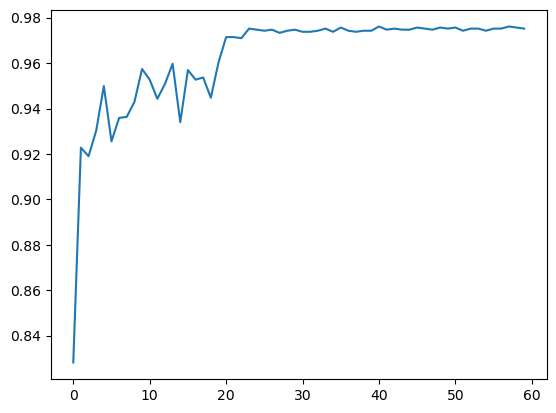

In [19]:
print(max(acc_list),np.argmax(np.array(acc_list)))
plt.plot(acc_list)

In [19]:
sent_dataloader = DataLoader(test_data, batch_size=1, shuffle=False)
model.train(False)
preds = sent_loop(sent_dataloader, model, loss_fn)

C:\Users\Артур\AppData\Local\Temp\ipykernel_3312\2074941755.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  target_transform=lambda y: torch.zeros(1000, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)


Test Error: 
 Accuracy: 97.6%, Avg loss: 0.161525 



In [22]:
print(len(preds))
d = {'id': np.arange(0,2136), 'label3': preds}
df=pd.DataFrame(data=d)
print(df)
df.to_csv('pred3.csv', index=False, header=True)

2136
        id  label3
0        0       0
1        1       0
2        2       0
3        3       0
4        4       0
...    ...     ...
2131  2131      45
2132  2132      45
2133  2133      45
2134  2134      45
2135  2135      45

[2136 rows x 2 columns]
